### Lectura de los correos

In [1]:
from nltk import download
download('punkt', download_dir='.')

from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk.data import load

root1 = './Enron-Spam/subconjuntos/train/legítimo'
corpus_entrenamiento_legitimo = PlaintextCorpusReader(root1, '.*', encoding='latin-1',
                                             sent_tokenizer=load('tokenizers/punkt/spanish.pickle'))

root2 = './Enron-Spam/subconjuntos/train/no_deseado'
corpus_entrenamiento_no_deseado = PlaintextCorpusReader(root2, '.*', encoding='latin-1',
                                             sent_tokenizer=load('tokenizers/punkt/spanish.pickle'))

root3 = './Enron-Spam/subconjuntos/val/legítimo'
corpus_prueba_legitimo = PlaintextCorpusReader(root3, '.*', encoding='latin-1',
                                             sent_tokenizer=load('tokenizers/punkt/spanish.pickle'))

root4 = './Enron-Spam/subconjuntos/val/no_deseado'
corpus_prueba_no_deseado = PlaintextCorpusReader(root4, '.*', encoding='latin-1',
                                             sent_tokenizer=load('tokenizers/punkt/spanish.pickle'))

[nltk_data] Downloading package punkt to ....
[nltk_data]   Package punkt is already up-to-date!


### Eliminación de ruido y Tokenización

In [2]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def denoise_text(text):
    text = strip_html(text)
    text = replace_contractions(text)
    return text

In [3]:
import time
import nltk
from bs4 import BeautifulSoup
import contractions # puede que sea necesario hacer un pip install contractions en la consola de comandos de anaconda

In [4]:
#Eliminación de ruido y tokenización de los correos de entrenamiento, y creación de la lista de las clases de cada correo
inicio = time.time()

tokenized_words_legitimo = []
tokenized_words_no_deseado = []
dataset = []
clases_entrenamiento = []

for filename in corpus_entrenamiento_legitimo.fileids():
    denoise_email = denoise_text(corpus_entrenamiento_legitimo.raw(filename))
    dataset.append(denoise_email)
    clases_entrenamiento.append('legitimo')
    tokenized_words_legitimo += nltk.word_tokenize(denoise_email)
    
tiempo_legitimo = time.time()
print('Tiempo primer corpus: ' + str(tiempo_legitimo - inicio))
    
for filename in corpus_entrenamiento_no_deseado.fileids():
    denoise_email = denoise_text(corpus_entrenamiento_no_deseado.raw(filename))
    dataset.append(denoise_email)
    clases_entrenamiento.append('spam')
    tokenized_words_no_deseado += nltk.word_tokenize(denoise_email)
    
tiempo_no_deseados = time.time()
print('Tiempo segundo corpus: ' + str(tiempo_no_deseados - tiempo_legitimo))   
    
final = time.time()
print('Tiempo total: ' + str(final-inicio))

Tiempo primer corpus: 71.92181587219238
Tiempo segundo corpus: 111.9568145275116
Tiempo total: 183.87863039970398


In [5]:
# Se tokenizan los correos de validación para poder aplicar la normalización más adelante

inicio_val = time.time()

clases_prueba = []
tokenized_words_validation = []

for filename in corpus_prueba_legitimo.fileids():
    email = corpus_prueba_legitimo.raw(filename)
    clases_prueba.append('legitimo')
    tokenized_words_validation.append(nltk.word_tokenize(email))
    
for filename in corpus_prueba_no_deseado.fileids():
    email = corpus_prueba_no_deseado.raw(filename)
    clases_prueba.append('spam')
    tokenized_words_validation.append(nltk.word_tokenize(email))
    
final_val = time.time()
print('Tiempo total: ' + str(final_val-inicio_val))

Tiempo total: 37.953675746917725


In [6]:
from sklearn import preprocessing
codificador_clases = preprocessing.LabelEncoder()
clases_codificadas = codificador_clases.fit_transform(clases_entrenamiento)
clases_prueba_codificadas = codificador_clases.fit_transform(clases_prueba)

### Normalización

In [7]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)

    return words

In [8]:
#Normalizamos las palabras que se elegirán para el vocabulario
import re, string, unicodedata

inicio_normalizacion = time.time()
normalized_words_legitimo = normalize(tokenized_words_legitimo)
normalized_words_no_deseado = normalize(tokenized_words_no_deseado)
final_normalizacion = time.time()
print('Tiempo de ejecución: ' + str(final_normalizacion-inicio_normalizacion))

Tiempo de ejecución: 11.83104133605957


In [9]:
# esta lista contiene string correspondientes a los emails tras aplicarles la normalización
normalized_emails_validation = []

for tokenized_email in tokenized_words_validation:
    normalized_emails_validation.append(" ".join(normalize(tokenized_email)))

In [10]:
#Calculamos las 500 palabras más comunes de cada tipo de correo
from nltk.probability import FreqDist

fdist_legitimo = FreqDist(normalized_words_legitimo)
most_common_legitimo = fdist_legitimo.most_common(500)

fdist_legitimo = FreqDist(normalized_words_no_deseado)
most_common_no_deseado = fdist_legitimo.most_common(500)

In [11]:
#Creación del vocabulario
from nltk.lm import Vocabulary

vocabularyTermsRepeated = [word[0] for word in most_common_no_deseado] + [word[0] for word in most_common_legitimo]
vocabularyTerms = [word[0] for word in most_common_no_deseado] + [word[0] for word in most_common_legitimo]

# eliminamos aquellas palabras que aparezcan tanto en los no deseados como en los legitimos, ya que no nos serviran para
# diferenciar los correos
for word in vocabularyTermsRepeated:
    if vocabularyTerms.count(word) > 1:
        vocabularyTerms.remove(word)
        
vocab = Vocabulary(vocabularyTerms)

### Bag of Words + Naive Bayes Multinomial

In [12]:
#Entrenamiento del modelo Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

countvectorizer = CountVectorizer(vocabulary=vocab) #Creación del vectorizador con el vocabulario
count_entrenamiento = countvectorizer.fit_transform(dataset)
count_prueba = countvectorizer.transform(normalized_emails_validation)
count_tokens = countvectorizer.get_feature_names()
df_countvect = pd.DataFrame(data = count_entrenamiento.toarray(),index = corpus_entrenamiento_legitimo.fileids() + corpus_entrenamiento_no_deseado.fileids(),columns = count_tokens)
print("\nCount Vectorizer\n")
print(df_countvect)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(



Count Vectorizer

       2005  charset  0000  texthtml  microsoft  smtp  id  normal  \
0         0        1     0         0          0     0   1       0   
10002     0        1     0         0          0     0   1       0   
10003     0        1     0         0          0     0   1       0   
10004     0        1     0         0          0     0   1       0   
10005     0        1     0         0          0     0   1       0   
...     ...      ...   ...       ...        ...   ...  ..     ...   
9995      3        1     3         0          0     1   2       2   
9996      2        1     1         0          0     1   0       0   
9997      2        1     1         0          0     1   0       0   
9998      2        1     1         0          0     1   0       0   
9999      2        2     1         0          1     1   0       1   

       quotedprintable  jun  ...  companies  america  operation  part  her  \
0                    0    0  ...          0        0          0     0    0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
#Entrenamiento del modelo Naive-Bayes multinomial
from sklearn import naive_bayes

predicciones_NB = []

for k in range(1,20):
    multinomial_NB = naive_bayes.MultinomialNB(alpha=k)
    multinomial_NB.fit(count_entrenamiento.toarray(), clases_codificadas)
    prediccion_NB = multinomial_NB.predict(count_prueba.toarray())
    prediccion_NB = codificador_clases.inverse_transform(prediccion_NB)
    predicciones_NB.append(prediccion_NB)

### TF - IDF + kNN

In [14]:
#Entrenamiento del modelo Tf-Idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvectorizer = TfidfVectorizer(vocabulary=vocab) #Creamos el vectorizador y le pasamos el vocabulario
tfidf_entrenamiento = tfidfvectorizer.fit_transform(dataset)
tfidf_prueba = tfidfvectorizer.transform(normalized_emails_validation)
tfidf_tokens = tfidfvectorizer.get_feature_names()
df_tfidfvect = pd.DataFrame(data = tfidf_entrenamiento.toarray(),index = corpus_entrenamiento_legitimo.fileids() + corpus_entrenamiento_no_deseado.fileids(),columns = tfidf_tokens)
print("\nTD-IDF Vectorizer\n")
print(df_tfidfvect)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(



TD-IDF Vectorizer

           2005   charset      0000  texthtml  microsoft      smtp        id  \
0      0.000000  0.041569  0.000000       0.0   0.000000  0.000000  0.052257   
10002  0.000000  0.009651  0.000000       0.0   0.000000  0.000000  0.012132   
10003  0.000000  0.028315  0.000000       0.0   0.000000  0.000000  0.035595   
10004  0.000000  0.014994  0.000000       0.0   0.000000  0.000000  0.018849   
10005  0.000000  0.016339  0.000000       0.0   0.000000  0.000000  0.020540   
...         ...       ...       ...       ...        ...       ...       ...   
9995   0.208520  0.030900  0.217757       0.0   0.000000  0.068338  0.077689   
9996   0.189477  0.042117  0.098935       0.0   0.000000  0.093145  0.000000   
9997   0.095954  0.021329  0.050102       0.0   0.000000  0.047170  0.000000   
9998   0.178736  0.039729  0.093327       0.0   0.000000  0.087865  0.000000   
9999   0.117178  0.052093  0.061184       0.0   0.058584  0.057604  0.000000   

         normal  qu

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
#Entrenamiento del modelo Knn
from sklearn import neighbors

predicciones_kNN = []

for n_neighbors in range(1,20):
    clasif_kNN = neighbors.KNeighborsClassifier(n_neighbors)
    clasif_kNN.fit(tfidf_entrenamiento.toarray(), clases_codificadas)
    prediccion_kNN = clasif_kNN.predict(tfidf_prueba.toarray())
    prediccion_kNN = codificador_clases.inverse_transform(prediccion_kNN)
    predicciones_kNN.append(prediccion_kNN)

## Comparación algoritmos

In [16]:
def accuracy(tp, fp, fn, tn):
    # porcentaje total de elementos clasificados correctamente
    return (tp+tn)/(tp+fp+tn+fn)

def recall(tp, fp, fn, tn):
    # número de elementos identificados como positivos del total de verdaderos positivos
    return (tp)/(tp+fn)

def precision(tp, fp, fn, tn):
    # número de elementos identificados correctamente como positivos del total de elementos identificados como positivos
    return (tp)/(tp+fp)

def especificidad(tp, fp, fn, tn):
    # número de elementos correctamente identificados como negativos del total de negativos
    return (tn)/(tn+fp)

def f1_score(recall, precision):
    return (2*recall*precision)/(recall+precision)

In [17]:
from sklearn.metrics import confusion_matrix

def get_metrics(predicciones, objetivo_prueba):
    accuracy_list = []
    recall_list = []
    precision_list = []
    especificidad_list = []
    
    for prediccion in predicciones:
        confusion_matrix_algorithm = confusion_matrix(objetivo_prueba, prediccion)
        tp, fp, fn, tn = confusion_matrix_algorithm.ravel()
        accuracy_algorithm = accuracy(tp, fp, fn, tn)
        recall_algorithm = recall(tp, fp, fn, tn)
        precision_algorithm = precision(tp, fp, fn, tn)
        especificidad_algorithm = especificidad(tp, fp, fn, tn)
        
        accuracy_list.append(accuracy_algorithm)
        recall_list.append(recall_algorithm)
        precision_list.append(precision_algorithm)
        especificidad_list.append(especificidad_algorithm)
        
    return (accuracy_list, recall_list, precision_list, especificidad_list)

In [19]:
accuracy_NB_list, recall_NB_list, precision_NB_list, especificidad_NB_list = get_metrics(predicciones_NB, clases_prueba)

accuracy_kNN_list, recall_kNN_list, precision_kNN_list, especificidad_kNN_list = get_metrics(predicciones_kNN, clases_prueba)

In [20]:
hiperparametro = []
h_string = []

for n in range(1,20):
    hiperparametro.append(n)
    h_string.append(str(n))

In [21]:
import matplotlib.pyplot as plt

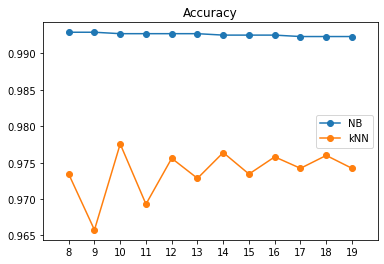

In [22]:
fig, ax = plt.subplots()
ax.plot(hiperparametro[7:], accuracy_NB_list[7:], marker='o', label= 'NB')
ax.plot(hiperparametro[7:], accuracy_kNN_list[7:], marker='o', label= 'kNN')

ax.legend(loc = 'center right')
ax.set_xlim([7, 20])

plt.title("Accuracy")
plt.xticks(hiperparametro[7:], h_string[7:])

plt.show()

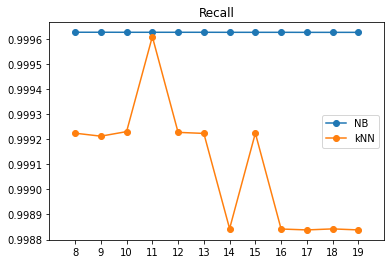

In [23]:
fig, ax = plt.subplots()
ax.plot(hiperparametro[7:], recall_NB_list[7:], marker='o', label= 'NB')
ax.plot(hiperparametro[7:], recall_kNN_list[7:], marker='o', label= 'kNN')

ax.legend(loc = 'center right')
ax.set_xlim([7, 20])

plt.title("Recall")
plt.xticks(hiperparametro[7:], h_string[7:])

plt.show()

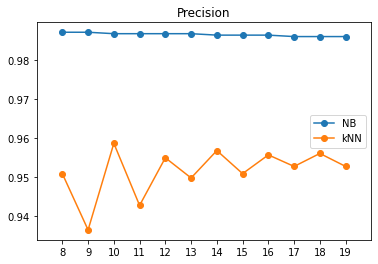

In [24]:
fig, ax = plt.subplots()
ax.plot(hiperparametro[7:], precision_NB_list[7:], marker='o', label= 'NB')
ax.plot(hiperparametro[7:], precision_kNN_list[7:], marker='o', label= 'kNN')

ax.legend(loc = 'center right')
ax.set_xlim([7, 20])

plt.title("Precision")
plt.xticks(hiperparametro[7:], h_string[7:])

plt.show()

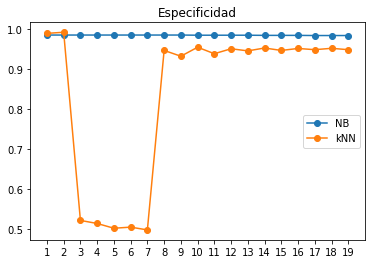

In [25]:
fig, ax = plt.subplots()
ax.plot(hiperparametro, especificidad_NB_list, marker='o', label= 'NB')
ax.plot(hiperparametro, especificidad_kNN_list, marker='o', label= 'kNN')

ax.legend(loc = 'center right')
ax.set_xlim([0, 20])

plt.title("Especificidad")
plt.xticks(hiperparametro, h_string)

plt.show()